<a href="https://colab.research.google.com/github/hchang18/DeepLearningTheoryPractice/blob/master/LSTM_Stock_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code


In [0]:
# Mount local drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [0]:
import torch.nn as nn
import torch.optim as optim

import random
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt
import time

# multivariate data preparation
from numpy import array
from numpy import hstack

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [0]:
# Hyperparameters: split sizes (percentages), note: testsize = 100 - train_sz
train_sz = 80  # currently 4/5 of the data (before val-data is removed)
val_sz = 20  # currently 1/5 of training
n_timesteps = 5 # this is number of timesteps (tau)
learn_rate = 0.001 #Hyperparam
train_episodes = 1000  # Hyperparam
batch_size = 16
num_hidden_states = 200
num_hidden_layers = 3

In [0]:
PATH = "/content/gdrive/My Drive/Colab Notebooks/FMCC.csv"
SAVE_PATH = "/content/gdrive/My Drive/Colab Notebooks"

with open(PATH, newline='') as csvfile:
    
    dictreader = csv.DictReader(csvfile, delimiter = ',')
    
    feature_names = dictreader.fieldnames
    all_data = list(dictreader)  # creates a list of dicts (1 per sample) using first row of csv for feature-names
    del all_data[-1]  # delete last item
    del all_data[0]  # delete first item
    del all_data[1506] # Volume == 0 causing problems (div by 0)
    del all_data[1507] # Volume == 0 causing problems (div by 0)
    data_length = len(all_data)

    inp_feats = ['Percentage Change (Low)','Percentage Change (High)' ,'Percentage Change (Close)', 'Percentage Change(Volume)', 'Percentage Change(Vix)', 'Percentage Change(S&P)']
    alternate_inp_feats = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'VIX Closed', 'S&P Close']
    outp_feat = 'Next Day Percentage Change (High)'

    for i, row in enumerate(all_data): 
        try: 
            all_data[i][outp_feat] = float(all_data[i][outp_feat][0:-1])
        except ValueError:
            print ('Line {} is corrupt!'.format(i))
            break
        
        for mat_feat in inp_feats:
          all_data[i][mat_feat] = float(all_data[i][mat_feat][0:-1])

        # alternate features
        # for mat_feat in alternate_inp_feats:
        #   all_data[i][mat_feat] = float(all_data[i][mat_feat])


    all_inps = np.array([[all_data[samp][feat] for feat in inp_feats] for samp in range(data_length)])
    all_outps = np.array([all_data[samp][outp_feat] for samp in range(data_length)]).reshape(data_length, 1)
    
    # alternate features
    # all_inps = np.array([[all_data[samp][feat] for feat in alternate_inp_feats] for samp in range(data_length)])
    
    n_features = len(inp_feats)

    dataset = hstack((all_inps, all_outps))

    print(dataset.shape)

(2513, 7)


In [0]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


In [0]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = num_hidden_states # number of hidden states
        self.n_layers = num_hidden_layers # number of LSTM layers (stacked)

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)

        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)

    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [0]:
# convert dataset into input/output
X, y = split_sequences(dataset, n_timesteps)

# split data into training/test/val
train_test_split =  int(train_sz * X.shape[0] // 100)
val_split = (val_sz * train_test_split // 100) 

valX = X[:val_split]
valy = y[:val_split]
trainX = X[val_split:train_test_split]
trainy = y[val_split:train_test_split]
testX = X[train_test_split:]
testy = y[train_test_split:]

# create NN
mv_net = MV_LSTM(n_features, n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=learn_rate)

In [0]:
# mv_net.train()
num_epoch = []
loss_list_train = []
loss_list_val = []

loss_order = 10
temp_lr = learn_rate

start_time = time.time()
for t in range(train_episodes):
    # train
    mv_net.train()
    for b in range(0, len(trainX), batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainy[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        # lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
        # lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch)
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 

        # experiment
        if loss.item() < (loss_order / 100):
          loss_order /= 100
          temp_lr /= 5
          for param_group in optimizer.param_groups:
            param_group['lr'] = temp_lr
          print('cut lr to', temp_lr)


    if t % 20 == 0:
        print('step : ' , t , 'loss : ' , loss.item())
    num_epoch.append(t)
    loss_list_train.append(loss.item())

    # estimate validation error per epoch
    for b in range(0,len(valX),batch_size):
        inpt = valX[b:b+batch_size,:,:]
        target = valy[b:b+batch_size]    

        x_batch_val = torch.tensor(inpt,dtype=torch.float32)  
        y_batch_val = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch_val.size(0))
        # lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
        # lstm_out.contiguous().view(x_batch.size(0),-1)
        output = mv_net(x_batch_val)
        loss_val = criterion(output.view(-1), y_batch_val)
        
    loss_list_val.append(loss_val.item())

minutes = (time.time() - start_time)
print("--- %s ---" % minutes)

step :  0 loss :  3.8780081272125244
step :  20 loss :  0.5336471199989319
cut lr to 0.0002
step :  40 loss :  0.0060434541665017605
step :  60 loss :  0.02789960242807865
step :  80 loss :  0.03549816831946373
--- 204.3520531654358 ---


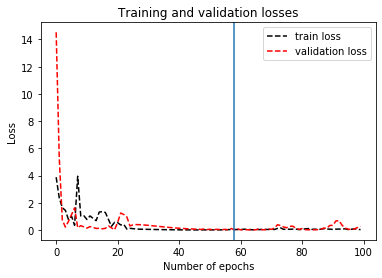

In [0]:
# plot two error curves 
d_epoch = np.array(num_epoch)
d_train = np.array(loss_list_train)
d_val = np.array(loss_list_val)
val_min = np.argmin(loss_list_val)

fig, ax = plt.subplots()
ax.plot(d_epoch, d_train, 'k--', label = 'train loss')
ax.plot(d_epoch, d_val, 'r--', label = 'validation loss')
plt.axvline(val_min)
ax.set_title("Training and validation losses")
ax.set_xlabel("Number of epochs")
ax.set_ylabel("Loss")
ax.legend(loc='best')
fig.show()

In [0]:
# test - print out the output
batch_size = 1
num_correct = 0
num_incorrect = 0
mae = []
for b in range(0,len(testX),batch_size):
    inpt = testX[b:b+batch_size,:,:]
    target = testy[b:b+batch_size]    

    x_batch = torch.tensor(inpt,dtype=torch.float32)  
    y_batch = torch.tensor(target,dtype=torch.float32)

    mv_net.init_hidden(x_batch.size(0))   
    output = mv_net(x_batch)
    abs_diff = np.absolute(output.detach().numpy() - target) 
    mae.append(abs_diff)
    # print('ground_truth: ', target, 'output: ', output)

    if(np.sign(target) == np.sign(output.detach().numpy())):
      num_correct += 1
    else:
      num_incorrect += 1

mae = np.array(mae)
mae_avg = np.mean(mae)
print('Mean Absolute Error: ', mae_avg)
print('correct:', num_correct)
print('incorrect:', num_incorrect)
print(num_correct/ (num_correct + num_incorrect))
print('train size: ', len(trainX))
print('test size: ', len(testX))


Mean Absolute Error:  2.4806262317549184
correct: 284
incorrect: 218
0.5657370517928287
train size:  1606
test size:  502


In [0]:
# model_save_name = 'mvnet_state_CCL_moredata'
# save_path = F'{SAVE_PATH}/{model_save_name}'
# torch.save(mv_net.state_dict(), save_path)

# model.load_state_dict(torch.load(save_path))

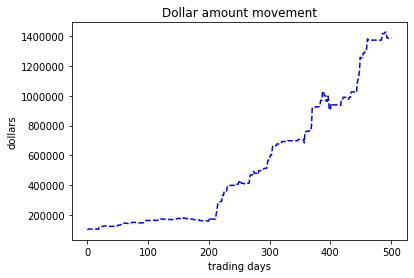

In [0]:
# dollar calculation
day = []
dollar_list = []

dollars = 100000
threshold = 1.0
# number of actually trading 
count = 0 
count_list = []
batch_size = 1
for b in range(0,len(testX),batch_size):
    inpt = testX[b:b+batch_size,:,:]
    target = testy[b:b+batch_size]    
    x_batch = torch.tensor(inpt,dtype=torch.float32)  
    y_batch = torch.tensor(target,dtype=torch.float32)
    mv_net.init_hidden(x_batch.size(0))
    # lstm_out, _ = mv_net.l_lstm(x_batch,nnet.hidden)    
    # lstm_out.contiguous().view(x_batch.size(0),-1)
    output = mv_net(x_batch) 
    if output.detach().numpy() > threshold:
        # print(target)
        day.append(b)
        # print(b)
        dollars *= (1 + (target[0])/100)
        # print(type(int(dollars)))
        count += 1
        dollar_list.append(dollars)
    else: 
        day.append(b)
        # print(b)
        # print(type(int(dollars)))
        dollar_list.append(dollars)

# print(day)
# print(dollar_list)


fig, ax = plt.subplots()
ax.plot(day, dollar_list, 'b--', label = 'dollar amount movement')
ax.set_xlabel("trading days")
ax.set_ylabel("dollars")
ax.set_title("Dollar amount movement")
fig.show()

Copyright: Luke Ding, Haeyoon Chang, Gabe Golden
